# Qubit-data for Lithium Hydride

In [1]:
import pickle
from pylab import *
import numpy as np
import math as m
from functools import reduce
import matplotlib.pyplot as plt

## Preliminaries

The fermionic Hamiltonian in second quantization (with $M$ orbitals)

$$ H = \sum_{\alpha,\beta=1}^M t_{\alpha\beta}c^\dagger_\alpha c_\beta 
+ \frac{1}{2}\sum_{\alpha\beta=1}^M\sum_{\gamma\delta=1}^M u_{\alpha\beta\gamma\delta}c^\dagger_\alpha c^\dagger_\gamma c_\delta c_\beta$$

is mapped into a qubit Hamiltonian in the form

$$ H = \sum_kc_kP_k $$

where $c_k$ are interaction coefficients and $P_k$ are elements of the $N$-qubit Pauli group $\mathcal{P}_N=\{\mathbb{1},X,Y,Z\}^{\otimes N}$.

The interaction coefficients and the Pauli operators can be found in the `interaction.file` and the `pauli.file` respectively.

Specifics:
- Number of qubits: 4
- Molecule geometry: bond distance
- Fermionic basis: atomic STO-3G
- Qubit mapping: spin-parity

## Exact diagonalization

In [2]:
# Identity 
I = np.asarray([[1.,0.],[0.,1.]])
# Pauli X
X = np.asarray([[0.,1.],[1.,0.]])
# Pauli Y
Y = np.asarray([[0.,-1j],[1j,0.]])
# Pauli Z
Z = np.asarray([[1.,0.],[0.,-1.]])

In [3]:
def operatorfromstring(pauli_string):
    """
    Generate a many-body operator from a list of single-qubit 
    pauli matrices.
    ---------------------------------------------------------
    Input    pauli_string: str , (ex: [X,Z,X,Y,...])
    
    Output   pauli_op: np.array, shape = [2**N,2**N]
    """
    op_list = []
    for k in range(len(pauli_string)):
        if (pauli_string[k] == 'X'):
            op_list.append(X)
        elif (pauli_string[k] == 'Y'):
            op_list.append(Y)
        elif (pauli_string[k] == 'Z'):
            op_list.append(Z)
        else:
            op_list.append(I)

    return reduce(np.kron,op_list)

def hamiltonian(pauli_list,interactions):
    """
    Generate a many-body hamiltonian
    ---------------------------------------------------------
    Input    pauli_list: list of pauli strings
             interactions: list of interaction strengths
    
    Output   hamiltonian: np.array, shape = [2**N,2**N]
    """
    N = len(pauli_list[0])
    hamiltonian = np.zeros((1<<N,1<<N),dtype=complex)
    for i,pauli in enumerate(pauli_list):
        hamiltonian += interactions[i]*operatorfromstring(pauli)
    return hamiltonian

def eigensolve(hamiltonian):
    """
    Compute ground state energy and wavefunction
    """
    (eigenvalues,eigenstates) = np.linalg.eigh(hamiltonian)
    return eigenvalues[0],eigenstates[:,0]

In [4]:
pauli_list   = np.load('paulis.file',allow_pickle=True)
interactions = np.load('interactions.file',allow_pickle = True)
for k in range(10):
    print('Pauli:',pauli_list[k],' | Interaction: %.3E' % interactions[k])
print('...')

Pauli: IIII  | Interaction: -8.022E+00
Pauli: ZIII  | Interaction: -9.276E-02
Pauli: XZII  | Interaction: -2.941E-03
Pauli: XIII  | Interaction: 2.941E-03
Pauli: ZZII  | Interaction: -2.119E-01
Pauli: YYII  | Interaction: 7.428E-04
Pauli: XXII  | Interaction: -7.428E-04
Pauli: ZXII  | Interaction: 1.939E-02
Pauli: IXII  | Interaction: 1.939E-02
Pauli: IZII  | Interaction: 3.653E-01
...


In [5]:
# Build the full Hamiltonian and get the ground state energy / wavefunction
H = hamiltonian(pauli_list,interactions)
E0,psi0 = eigensolve(H)
print('Ground state energy: %.10f\n' % E0 )
print('Ground state wavefunction:\n\n',psi0)

Ground state energy: -8.9073963113

Ground state wavefunction:

 [-4.96394908e-03+0.j  2.53269627e-16+0.j -5.76276175e-02+0.j
  1.11651339e-01+0.j -3.26381702e-02+0.j  5.08356315e-16+0.j
  3.54539651e-02+0.j -5.76276175e-02+0.j  1.38777878e-16+0.j
  1.23592416e-25+0.j  5.01265465e-18+0.j -1.14084922e-17+0.j
 -9.88663405e-01+0.j -2.63778775e-17+0.j -3.26381702e-02+0.j
 -4.96394908e-03+0.j]


 ## Neural-network reconstruction

Quantum state reconstruction of the LiH ground state with a restricted Boltzmann machine, using the NetKet library.

References:
- _"Machine learning quantum states in the NISQ era"_ : review of quantum state reconstruction with restricted Boltzmann machines. https://arxiv.org/abs/1905.04312
- _"Precise measurement of quantum observables with neural-network estimators"_ RBM reconstruction of molecular ground states. https://arxiv.org/abs/1910.07596
- _"NetKet: A Machine Learning Toolkit for Many-Body Quantum Systems"_ Overview of the NetKet software library. https://arxiv.org/abs/1904.00031

In [6]:
from mpi4py import MPI 
import netket as nk

In [7]:
# Unitary matrices for the rotation in the X and Y bases
rotationX = 1./(math.sqrt(2))*np.asarray([[1.,1.],[1.,-1.]])
rotationY= 1./(math.sqrt(2))*np.asarray([[1.,-1j],[1.,1j]])

def LoadData(N,hilbert,path_to_samples, path_to_bases):
    training_samples = []
    training_bases = []

    tsamples = np.loadtxt(path_to_samples)
    assert(N == tsamples.shape[1])
    fin_bases = open(path_to_bases, 'r')
    lines = fin_bases.readlines()

    bases = []

    for b in lines:
        basis = ""
        assert(len(b) == N + 1)
        for j in range(N):
            basis += b[j]
        bases.append(basis)
    index_list = sorted(range(len(bases)), key=lambda k: bases[k])
    bases.sort()

    for i in range(len(tsamples)):
        training_samples.append(tsamples[index_list[i]].tolist())

    rotations = []

    tmp = ''
    b_index = -1
    for b in bases:
        if (b != tmp):
            tmp = b
            localop = nk.operator.LocalOperator(hilbert, 1.0)

            for j in range(N):
                if (tmp[j] == 'X'):
                    localop *= nk.operator.LocalOperator(hilbert, rotationX, [j])
                if (tmp[j] == 'Y'):
                    localop *= nk.operator.LocalOperator(hilbert, rotationY, [j])

            rotations.append(localop)
            b_index += 1
        training_bases.append(b_index)

    return tuple(rotations), np.asarray(training_samples), np.asarray(training_bases)

def OperatorFromString(op_string):                                                
    OpList = []                                                                   
    Sites = []                                                                    
    for k in range(len(op_string)):                                               
        if (op_string[k] == 'X'):                                                 
            OpList.append(X)                                                      
            Sites.append(k)                                                       
        elif (op_string[k] == 'Y'):                                               
            OpList.append(Y)                                                      
            Sites.append(k)                                                       
        elif (op_string[k] == 'Z'):                                               
            OpList.append(Z)                                                      
            Sites.append(k)                                                       
    return Sites,reduce(np.kron,OpList) 

def BuildHamiltonian(N,hilbert,pauli_path,interactions_path):                     
    pauli = np.load(pauli_path,allow_pickle=True)                                 
    interactions = np.load(interactions_path,allow_pickle=True)                   
                                                                                  
    hamiltonian = nk.operator.LocalOperator(hilbert, 0.0)                                                                                 
    for h in range(0,len(pauli)):                                                                                           
        flag = 0                                                                  
        for j in range(N):                                                        
            if (pauli[h][j]!='I'): flag = 1; break                                
        if flag == 0:                                                             
            hamiltonian += nk.operator.LocalOperator(hilbert,np.real(interactions[h]))
        else:                                                                     
            sites,operator = OperatorFromString(pauli[h])                         
            h_term = interactions[h]*operator
            hamiltonian += nk.operator.LocalOperator(hilbert,h_term,sites)        
            
    return hamiltonian 

In [8]:
N = 4          # Number of qubits
ns = 100000    # Number of training samples
lr = 0.01      # Learning rate
M = 10000      # Number of samples for the negative CD phase
bs = 1000      # Batch size
epochs = 500   # Epochs

samples_path = "train_samples.txt"
bases_path = "train_bases.txt"
pauli_path = "paulis.file"
interactions_path = "interactions.file"

In [9]:
# Lattice
graph = nk.graph.Hypercube(length=N, n_dim=1,pbc=False)
# Hilbert space
hilbert = nk.hilbert.Qubit(graph=graph)
# NetKet Hamiltonian
hamiltonian = BuildHamiltonian(N,hilbert,pauli_path,interactions_path)

In [10]:
# Load training data
rotations, tr_samples, tr_bases = LoadData(N,hilbert,samples_path, bases_path)
if (ns > tr_samples.shape[0]):
    "Not enough training samples"
else:
    training_samples = tr_samples[0:ns]
    training_bases   = tr_bases[0:ns]

In [11]:
# RBM wavefunction
# ma = nk.machine.RbmSpinPhase(hilbert=hilbert, alpha=1)  # Real-weights RBM (amplitude + phase)
ma = nk.machine.RbmSpin(hilbert=hilbert, alpha=1)        # Complex-weights RBM, alpha=num_hidden/N
ma.init_random_parameters(seed=1234, sigma=0.01)

In [12]:
# Sampler
sa = nk.sampler.MetropolisLocal(machine=ma)

# Optimizer + Stochastic Reconfiguration
#op = nk.optimizer.Sgd(learning_rate=lr)
op = nk.optimizer.RmsProp(learning_rate=lr,beta=0.9,epscut = 1.0e-6)
sr = nk.optimizer.SR(diag_shift=0.1)

In [13]:
# Quantum state tomography object
qst = nk.Qsr(
    sampler=sa,
    optimizer=op,
    samples=training_samples,
    rotations=rotations,
    bases=training_bases,
    n_samples=M,
    n_samples_data=bs,
    sr=sr,
    #sr=None
)
# Measure the energy while training
qst.add_observable(hamiltonian, "Energy")

/Users/user/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Call to deprecated function 'add_observable'
  


In [14]:
# Training loop
import re
energy = []
radii = []
variance = []
test = []

for ep in qst.iter(epochs, 10):
    # Get energy measurement
    obs = qst.get_observable_stats()
    
    #===============
    splited = str(obs['Energy']).split(" ")
    energy.append(splited[1][2:])
    radii.append(splited[6][2:9])
    variance.append(splited[5][5:11])
    test.append(re.findall(r"[-+]?\d*\.\d+|\d+", str(obs['Energy'])))
#     print(splited)
    #==================
    
    # Compute fidelity with exact state
    psima = ma.to_array()
    overlap = np.abs(np.vdot(psima, psi0))
    
    print('Epoch = %d   ' % ep,end='')
    print('Overlap = %.6f   '% overlap,end='')
    print("observables={}".format(obs))

/Users/user/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Call to deprecated function 'get_observable_stats'
  # Remove the CWD from sys.path while we load stuff.


Epoch = 0   Overlap = 0.259903   observables={'Energy': (-7.972 - 0.000i) ± 0.012 [var=0.462, R=1.00190], '': None}


/Users/user/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Call to deprecated function 'get_observable_stats'
  # Remove the CWD from sys.path while we load stuff.


Epoch = 10   Overlap = 0.320278   observables={'Energy': (-8.0218 + 0.0001i) ± 0.0064 [var=0.5191, R=0.99984], '': None}
Epoch = 20   Overlap = 0.372760   observables={'Energy': (-8.0749 - 0.0002i) ± 0.0074 [var=0.5301, R=1.00003], '': None}
Epoch = 30   Overlap = 0.436882   observables={'Energy': (-8.1427 + 0.0003i) ± 0.0068 [var=0.5292, R=0.99990], '': None}
Epoch = 40   Overlap = 0.511383   observables={'Energy': (-8.242 - 0.001i) ± 0.010 [var=0.503, R=1.00080], '': None}
Epoch = 50   Overlap = 0.595833   observables={'Energy': (-8.3294 + 0.0001i) ± 0.0079 [var=0.4797, R=1.00023], '': None}
Epoch = 60   Overlap = 0.685978   observables={'Energy': (-8.4612 - 0.0006i) ± 0.0094 [var=0.3997, R=1.00096], '': None}
Epoch = 70   Overlap = 0.769201   observables={'Energy': (-8.5607 + 0.0004i) ± 0.0086 [var=0.3221, R=1.00103], '': None}
Epoch = 80   Overlap = 0.853787   observables={'Energy': (-8.6723 - 0.0003i) ± 0.0087 [var=0.2343, R=1.00181], '': None}
Epoch = 90   Overlap = 0.915674   ob

x_val [1.0019, 0.99984, 1.00003, 0.9999, 1.0008, 1.00023, 1.00096, 1.00103, 1.00181, 1.00273, 1.0184, 1.02625, 1.01837, 1.02232, 1.04333, 1.01867, 1.01509, 1.05788, 1.03004, 1.07722, 1.04622, 1.03218, 1.05029, 1.00862, 1.00408, 1.01181, 1.00582, 1.01316, 1.0035, 1.01393, 1.01159, 1.00736, 1.01659, 1.00583, 1.00532, 1.00137, 1.01735, 1.0, 1.01269, 1.00852, 1.00952, 1.00464, 1.00638, 1.03632, 1.01372, 1.01571, 1.00197, 1.00524, 1.00379, 1.00757]
y_val [-7.972, -8.0218, -8.0749, -8.1427, -8.242, -8.3294, -8.4612, -8.5607, -8.6723, -8.7851, -8.803, -8.85, -8.8631, -8.8679, -8.859, -8.8881, -8.8918, -8.871, -8.8874, -8.88, -8.8912, -8.8921, -8.895, -8.9033, -8.9035, -8.9056, -8.9071, -8.9048, -8.901, -8.902, -8.9055, -8.9035, -8.9043, -8.9051, -8.9065, -8.90497, -8.9081, -8.9061, -8.9062, -8.9063, -8.9057, -8.9053, -8.9033, -8.9048, -8.9064, -8.9078, -8.90541, -8.90678, -8.90506, -8.90685]


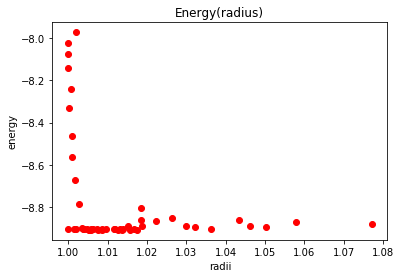

In [15]:
# plot 
x_val = []
y_val = []
var = []

for data in range(len(test)):
    y_val.append(float(test[data][0]))
    x_val.append(float(test[data][4]))
    var.append(float(test[data][3]))
    
print("x_val", x_val)
print("y_val", y_val)

plt.plot(x_val, y_val,'ro')
plt.xlabel('radii')
plt.ylabel('energy')
plt.title('Energy(radius)')
plt.show()